In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyhacores.fft import R2SDF
from pyhacores.fft.util import *
from pyhacores.fft.packager import DataWithIndex, Packager, unpackage, package
from scipy.fftpack import fft, fftshift

def make_fft(window):
    A = fft(window, N * 8) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    return freq, response

fft_size = 128
input_signal = np.random.uniform(-1, 1, size=(2, fft_size)) + np.random.uniform(-1, 1, size=(2, fft_size)) * 1j
input_signal *= 0.125

## Forward FFT

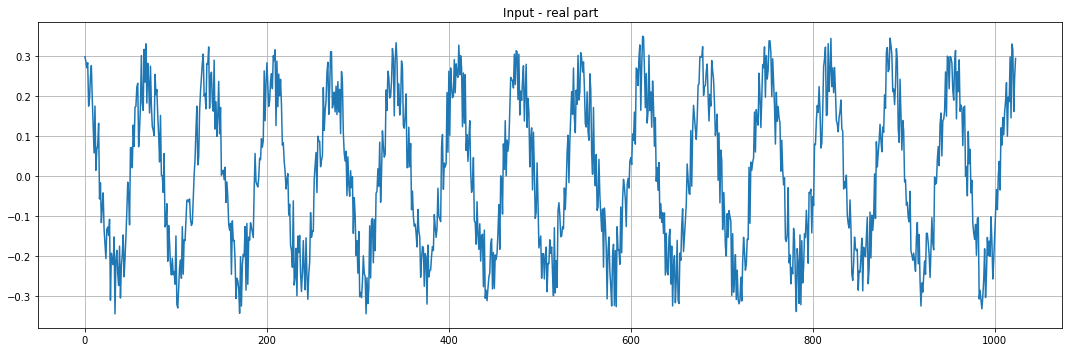

In [4]:
fft_size = 256
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
# input_signal = [1.0 + 1.0j] * 512 # this input signal basically just returns the window taps
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
input_signal = sine + noise * 0.1
plt.title('Input - real part')
plt.plot(input_signal.real)
show_plot()

In [5]:
fft_256 = R2SDF(fft_size, twiddle_bits=18)
fft_sims = simulate(fft_256, input_signal, output_callback=unpackage, input_callback=package, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1304/1304 [00:03<00:00, 433.50it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
snr(fft_sims['MODEL'], fft_sims['PYHA'])

63.426361893715566

## FFT to spectrum
Have to keep in mind that the output is in bit reversed ordering...
Also take a look at the 'Spectrogram' core that performs this in FPGA.

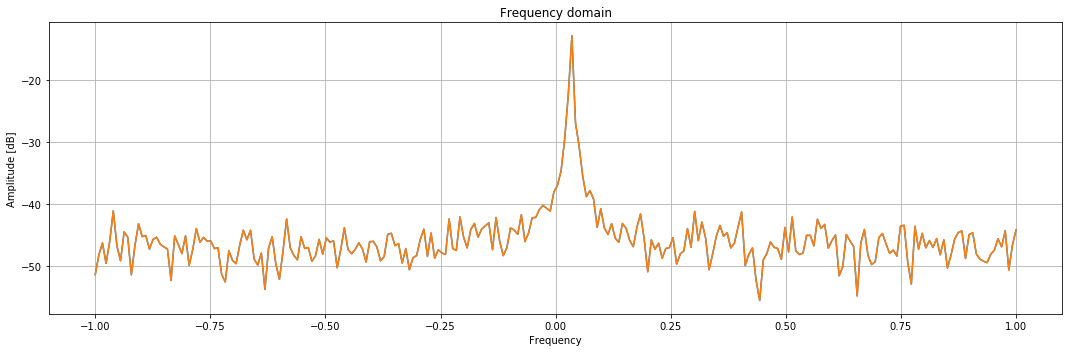

In [7]:
plt.title('Frequency domain')
gain_fix = len(input_signal)
for key, value in fft_sims.items():
    spectrum = 20 * np.log10(np.mean(np.abs(np.array(value)), axis=0))
    spectrum = toggle_bit_reverse(spectrum, fft_size) # fix bit-reversed ordering
    spectrum = np.fft.fftshift(spectrum)
    plt.plot(np.linspace(-1, 1, fft_size), spectrum)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()

## Inverse FFT
We are using the inputs from previous stage, that is in 'bitreversed' ordering. Thats why we have to run the IFFT with 'input_ordering = bitreversed'.

In [8]:
ifft_256 = R2SDF(fft_size, twiddle_bits=18, inverse=True, input_ordering='bitreversed')
sims = simulate(ifft_256, fft_sims['PYHA'], output_callback=unpackage, input_callback=package, simulations=simulations)


INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1304/1304 [00:02<00:00, 441.39it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [9]:
snr(np.array(sims['MODEL']), sims['PYHA'])

79.34163929737755

In [10]:
snr(input_signal, np.array(sims['PYHA']).flatten())

70.54948553994335

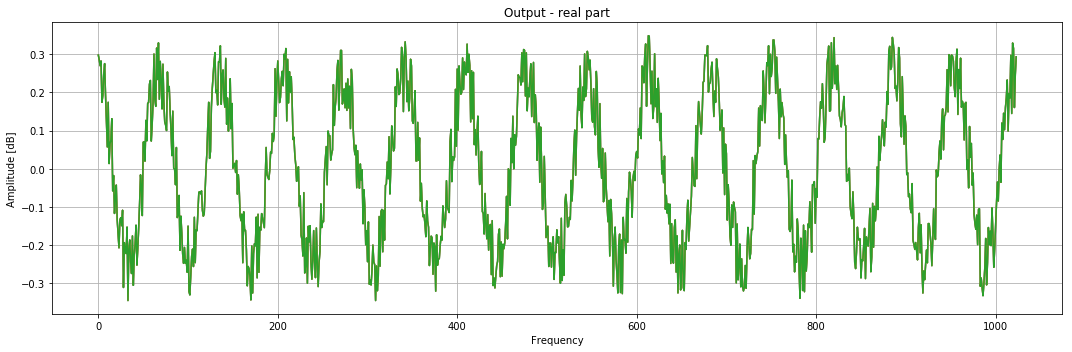

In [11]:
plt.title('Output - real part')
# for key, value in sims.items():
plt.plot(np.array(sims['MODEL']).flatten())
plt.plot(np.array(sims['PYHA']).flatten())
plt.plot(input_signal)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
# plt.ylim([-120, 1])
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [12]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Coefficients are stored as constants in LUTs
Storing 18bit coefficnets for large FFT can take huge amounts of LUTS. I recommend using bitwidth of ~8, this gives quite optimal packing. Note that ~8 bit coefficents might look bad on synthetic signals but are acutally very much usable on real-life signals.

## Output ordering is different from numpy
Numpy has `Natural(in) -> Natural(out)` ordering. 

This cores provide either `Natural -> Bitreversed` or `Bitreversed -> Natural` ordering. This is the side-effect of Radix-2 algorithm, this can be fixed with the 'Bitreversal' core.

## Scaling is different from numpy
Numpy scales `fft_out *= FFT_LENGHT` and `ifft_out /= FFT_LENGHT`. 

This core works in oppsite i.e. `fft_out /= FFT_LENGHT` and `ifft_out *= FFT_LENGHT`. This way the values always stay in -1 ... 1 range.

# Synthesis

## FFT 256

In [13]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(fft_256, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:DataWithIndex to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:R2SDF to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 10 18:26:22 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_proje

In [14]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 2695
Memory: 8640
Multipler (18bit): 28


## IFFT 256

In [15]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(ifft_256, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:DataWithIndex to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:R2SDF to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 10 18:26:47 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_proje

In [16]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 2628
Memory: 8718
Multipler (18bit): 28
